In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 189 kB 8.1 MB/s 
     |████████████████████████████████| 56 kB 5.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [11]:
from google.colab import drive
import pandas as pd
from fastai.vision.all import *
import cv2

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!mkdir data
!unrar x drive/My\ Drive/CarClassification/dataset.rar data

Streaming output truncated to the last 5000 lines.
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_FKQ.jpg      91%  OK 
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_GGR.jpg      91%  OK 
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_GWL.jpg      91%  OK 
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_IiW.jpg      91%  OK 
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_iTX.jpg      91%  OK 
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_jdQ.jpg      91%  OK 
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_JFf.jpg      91%  OK 
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_jpO.jpg      91%  OK 
Extracting  data/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_KMw.jpg      91%  OK 
Extr

In [4]:
df = pd.read_csv("filenames_with_car_flags_bw_added.csv",index_col=0, header=None).squeeze()

In [5]:
import os
len(os.listdir("data"))

64467

In [6]:
!mkdir filtered

In [13]:
i=0
err=0
fnnames=[]
for index,value in df.items():
  if(value==True):
    split=index.split("_")
    name = ("_".join(split[0:2]))+"-"+split[-1]+".jpg"
    try:
      img = cv2.imread("data/"+index)
      img = cv2.resize(img,(224,224),interpolation = cv2.INTER_AREA)
      cv2.imwrite("filtered/"+name,img)
      #os.rename("data/"+index, "filtered/"+name)
      fnnames.append("filtered/"+name)
      #shutil.copy("data/"+index,"filtered/"+name+".jpg")
      i+=1
    except:
      err+=1
print(i)
print(err)

53783
0


In [27]:
#path = 'filtered/' # Define path to the image folders
# for f in os.listdir(path):
#     full_path = os.path.join(path, f)
#     if os.path.isfile(full_path):
#         fnnames.append(full_path)
print(len(fnnames))

53783


In [18]:
def labelfunc(fname):
  return fname.replace("filtered/","").replace(".jpg","").split('-')[0]

data = ImageDataLoaders.from_path_func(path="filtered/",fnames=fnnames,label_func=labelfunc,
                                  valid_pct=0.1,
                                  item_tfms=Resize(224), 
                                  num_workers=4, 
                                  bs = 128)

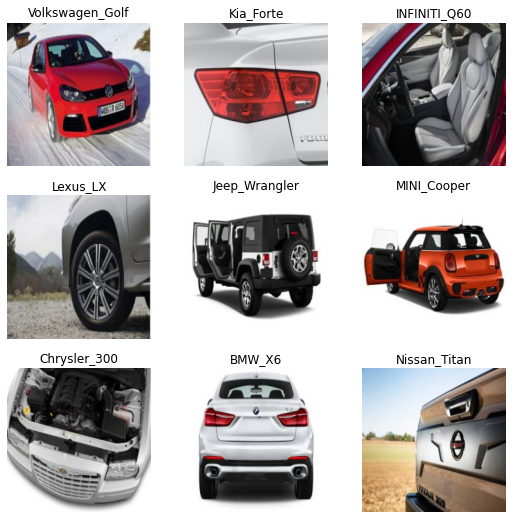

In [15]:
data.show_batch()

In [19]:
learn = cnn_learner(data, 
                    models.resnet18, 
                    metrics=[accuracy,error_rate], pretrained=True)

Load in weights from previous runs

In [60]:
#learn.load('classification_stg4') #This is the 80% accuracy model

Training

In [59]:
learn.fit_one_cycle(3,slice(7.585775892948732e-05))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.036066,1.435207,0.769245,0.230755,01:31
1,0.029176,1.440450,0.770919,0.229081,01:31
2,0.023668,1.428925,0.770919,0.229081,01:31


In [57]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.069682,1.497494,0.759204,0.240796,01:14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.223627,1.674661,0.741354,0.258646,01:31
1,0.139248,1.488874,0.757345,0.242655,01:31
2,0.053363,1.450596,0.763853,0.236147,01:31


SuggestedLRs(valley=7.585775892948732e-05)

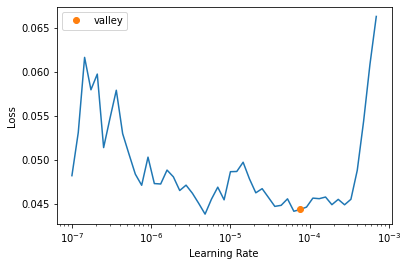

In [58]:
learn.unfreeze()
learn.lr_find()

In [70]:
learn.save('classification_stg5')

Path('filtered/models/classification_stg5.pth')

In [ ]:
learn.freeze()
learn.export(fname='export.pkl', pickle_module=pickle, pickle_protocol=2)

SuggestedLRs(valley=3.311311274956097e-06)

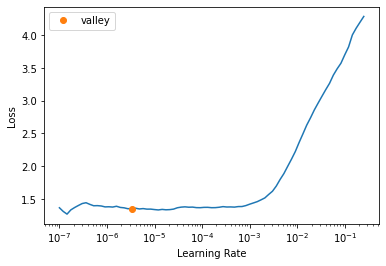

In [ ]:
learn.unfreeze()
learn.lr_find()

# Testing Predictions

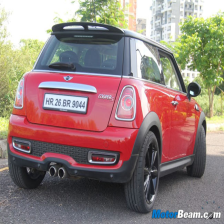

Time: 41080645
Prediction: MINI_Cooper


In [67]:
from google.colab.patches import cv2_imshow

img = cv2.imread('carimg1.jpeg')
img = cv2.resize(img,(224,224),interpolation = cv2.INTER_AREA)
cv2_imshow(img)
start = time.time_ns()
pred,pred_idx,probs = learn.predict(img)
print("Time: "+str(time.time_ns()-start))
print("Prediction: "+pred)

In [62]:
ind = np.argpartition(probs, -3)[-3:]
data.vocab[ind]

(#3) ['Volkswagen_Beetle','MINI_Cooper','MINI_Cooper Countryman']

### Exports to Pytorch/Pickle

In [ ]:
# learn.export()

In [ ]:
# path = Path("filtered")
# path.ls(file_exts='.pkl')

(#1) [Path('filtered/export.pkl')]

In [ ]:
# from google.colab import files
# files.download('filtered/export.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# export = load_learner('filtered/export.pkl')

In [ ]:
# torch.save(learn.model, "pytorchmodel.pt") # or save it's state_dict, better option

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

                               precision    recall  f1-score   support

                    Acura_ILX       0.60      0.60      0.60        15
                    Acura_MDX       0.79      0.79      0.79        33
                    Acura_NSX       0.67      0.62      0.65        16
                    Acura_RDX       0.78      0.70      0.74        20
                    Acura_RLX       0.75      0.64      0.69        14
                    Acura_TLX       0.75      0.82      0.78        11
                Alfa Romeo_4C       0.67      0.44      0.53         9
         Alfa Romeo_4C Spider       0.00      0.00      0.00         1
            Alfa Romeo_Giulia       0.83      0.56      0.67         9
           Alfa Romeo_Stelvio       0.50      0.50      0.50         4
            Aston Martin_DB11       0.50      0.40      0.44         5
             Aston Martin_DBS       0.55      0.75      0.63         8
        Aston Martin_Vanquish       0.67      0.80      0.73        10
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

### Saving classes to file

In [184]:
f = open("carClasses.txt",'w')
f.write(str(data.vocab))
f.close()

# Exporting to ONNX and making predictions.

In [72]:
!pip install onnxruntime onnx

In [177]:
import torch
import torchvision.transforms as transforms
import onnxruntime as rt

learn.model.eval()
torch.onnx.export(
    learn.model, 
    torch.randn(1, 3, 224, 224).cuda(),
    'carModel1.onnx',
    export_params=True,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['car'],
    opset_version=11,
)

In [180]:
to_tensor_and_norm = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

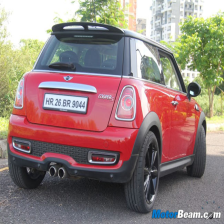

MINI_Cooper


In [181]:
sess = rt.InferenceSession('carModel1.onnx')
img = cv2.imread("carimg1.jpeg")
img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
imgy = [to_tensor_and_norm(img).tolist()]
# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

results = sess.run([output_name], {input_name: imgy})[0]
cv2_imshow(img)
print(data.vocab[np.argmax(results)])

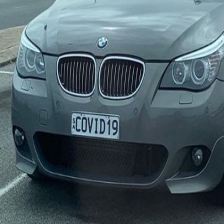

BMW_5


In [182]:
img = cv2.imread("carimg2.jpeg")
img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
imgy = [to_tensor_and_norm(img).tolist()]
# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

results = sess.run([output_name], {input_name: imgy})[0]
cv2_imshow(img)
print(data.vocab[np.argmax(results)])